# How to use LLM smartly? 

For a researcher, it is important to know how to use the LLM smartly. One of the useful application is to extract information from the paper.

Object:
1. extract the texts, tables, and figures paper
2. post process some texts, tables, and figures

## 1. PDF processing with pdfplumber

`pdfplumber`: Plumb a PDF for detailed information about each text character, rectangle, and line. Plus: Table extraction and visual debugging.

https://github.com/jsvine/pdfplumber

Several other Python libraries help users to extract information from PDFs. As a broad overview, pdfplumber distinguishes itself from other PDF processing libraries by combining these features:

* Easy access to detailed information about each PDF object
* Higher-level, customizable methods for extracting text and tables
* Tightly integrated visual debugging
* Other useful utility functions, such as filtering objects via a crop-box

It's also helpful to know what features pdfplumber does not provide:

* PDF generation
* PDF modification
* Optical character recognition (OCR)
* Strong support for extracting tables from OCR'ed documents

**Specific comparisons**

* `pdfminer.six` provides the foundation for pdfplumber. It primarily focuses on parsing PDFs, analyzing PDF layouts and object positioning, and extracting text. It does not provide tools for table extraction or visual debugging.
* `PyPDF2` is a pure-Python library "capable of splitting, merging, cropping, and transforming the pages of PDF files. It can also add custom data, viewing options, and passwords to PDF files." It can extract page text, but does not provide easy access to shape objects (rectangles, lines, etc.), table-extraction, or visually debugging tools.
* `pymupdf` is substantially faster than pdfminer.six (and thus also pdfplumber) and can generate and modify PDFs, but the library requires installation of non-Python software (MuPDF). It also does not enable easy access to shape objects (rectangles, lines, etc.), and does not provide table-extraction or visual debugging tools.
* `camelot`, `tabula-py`, and `pdftables` all focus primarily on extracting tables. In some cases, they may be better suited to the particular tables you are trying to extract.

In [1]:
import pdfplumber
from pathlib import Path
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

In [2]:
# load paper
file_path = Path("1706.03762v7.pdf").resolve()  # path to the paper
pdf = pdfplumber.open(file_path)  # open the paper
pages = pdf.pages  # get all pages objects

### Text Extraction

Now we can extract text with pdfplumber by calling page method `extract_text`.

* A `method` of an **object** is a function that belongs to the object.

In [4]:
# example of page
page = pages[0]
print(f'Type of `page` object: {type(page)}')
print(f'page witdh x height = {page.width} x {page.height}')
print('\n[Extracted Text]')
print(page.extract_text()[:1000])

Type of `page` object: <class 'pdfplumber.page.Page'>
page witdh x height = 612 x 792

[Extracted Text]
Providedproperattributionisprovided,Googleherebygrantspermissionto
reproducethetablesandfiguresinthispapersolelyforuseinjournalisticor
scholarlyworks.
Attention Is All You Need
AshishVaswani∗ NoamShazeer∗ NikiParmar∗ JakobUszkoreit∗
GoogleBrain GoogleBrain GoogleResearch GoogleResearch
avaswani@google.com noam@google.com nikip@google.com usz@google.com
LlionJones∗ AidanN.Gomez∗ † ŁukaszKaiser∗
GoogleResearch UniversityofToronto GoogleBrain
llion@google.com aidan@cs.toronto.edu lukaszkaiser@google.com
IlliaPolosukhin∗ ‡
illia.polosukhin@gmail.com
Abstract
Thedominantsequencetransductionmodelsarebasedoncomplexrecurrentor
convolutionalneuralnetworksthatincludeanencoderandadecoder. Thebest
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer,
basedsolelyonattentionmechanisms,dispensingwithrecu

Problem: the text is not well formatted. Some place need to add space to make it readable.

### Tables, Figures extraction

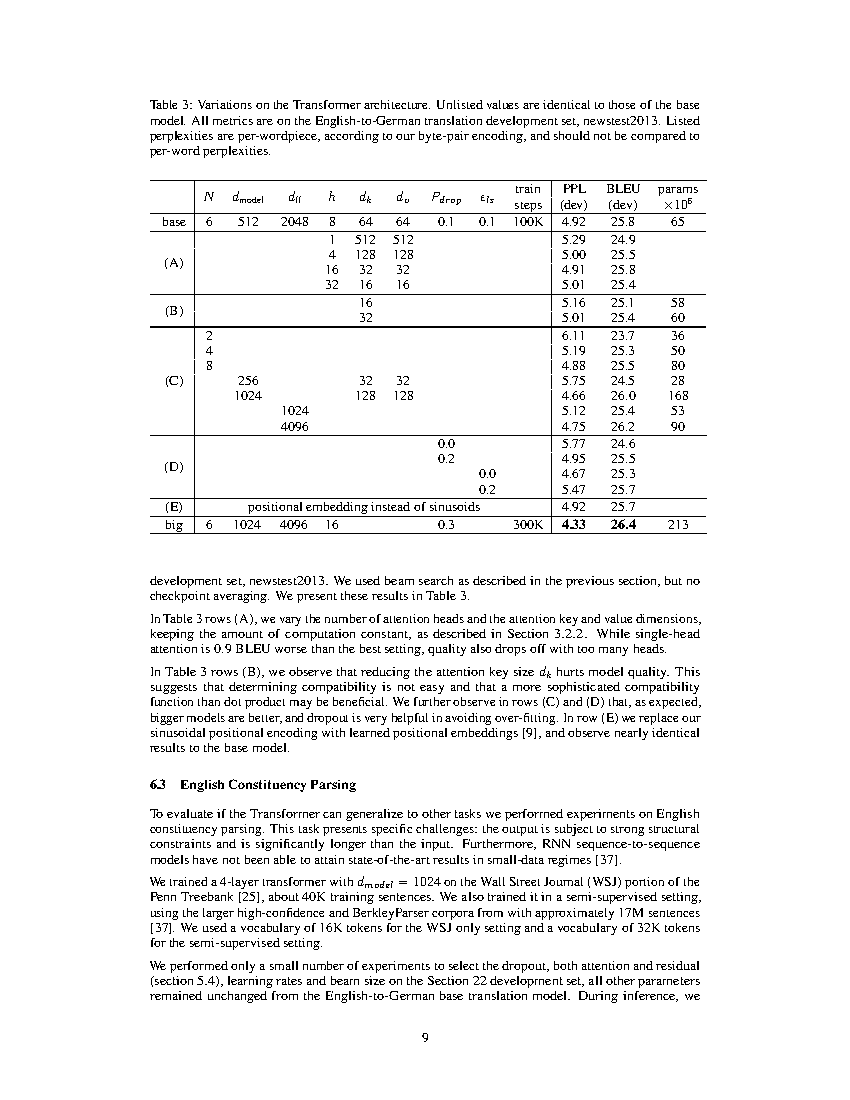

In [5]:
page = pages[8]
page.to_image(resolution=100)

`Layout-Parser` is a unified toolkit for deep learning based document image analysis

* The model predicts the bounding boxes of the `Text`, `Title`, `Table`, `List`, and `Figure` elements in the document.
    * Input: A page image(as a 3-D tensor). Shape of the image data should be (height, width, 3).
    * Output: A list of bounding boxes and element labels.
* The model is trained on the `PubLayNet` dataset, which contains 36000 document images with 17M annotated elements.

References: 

* https://layout-parser.github.io
* https://github.com/Layout-Parser/layout-parser
* https://github.com/Layout-Parser/layout-parser/blob/main/examples/Deep%20Layout%20Parsing.ipynb


The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


The shape of the image is (792, 612, 3)


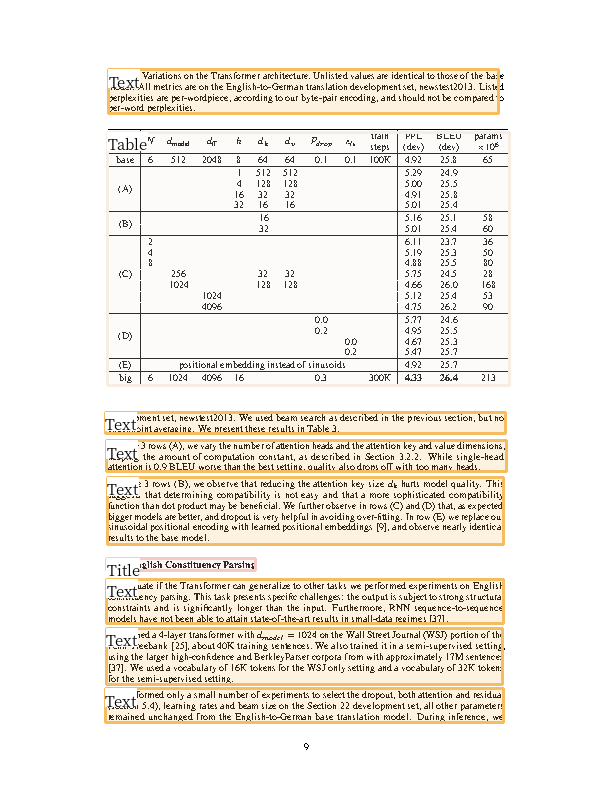

In [9]:
import numpy as np
import layoutparser as lp
import torchvision.ops.boxes as bops
from io import BytesIO
from PIL import Image
from pdfplumber.page import Page, CroppedPage
from layoutparser.models.detectron2 import Detectron2LayoutModel

def inference_page(p: Page | CroppedPage, model: Detectron2LayoutModel) -> tuple:
    img = p.to_image()
    imgfile = BytesIO()
    img.save(imgfile, format='png', quantize=False)
    img = np.array(Image.open(imgfile).convert('RGB'))  # convert the image into numpy array
    blocks = model.detect(img)
    return blocks, img

# lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config
# lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config
model = Detectron2LayoutModel(
    'lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config', 
    extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
    label_map={0: "Text", 1: "Title", 2: "List", 3: "Table", 4: "Figure"}
)

# using deep learning model to detect the layout of figures
blocks, img = inference_page(pages[8], model)
print(f'The shape of the image is {img.shape}')
lp.draw_box(img, blocks, box_width=3, box_alpha=0.2, show_element_type=True)

It returns the coordinates of (`x_0`, `y_0`, `x_1`, `y_1`) for each text box in the PDF.

x1: 107.6476, y1: 132.1216
x2: 509.3702, y2: 385.9351


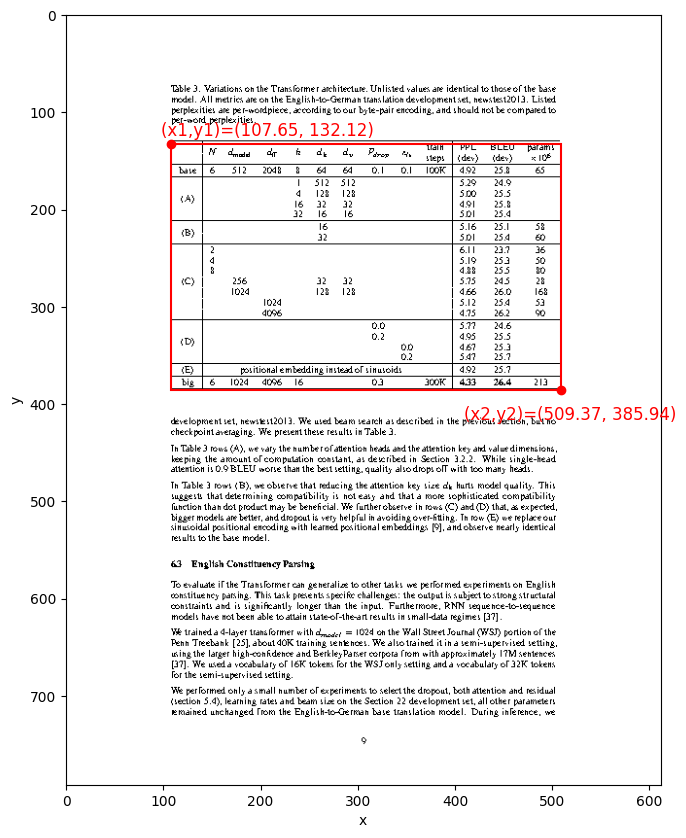

In [8]:
import matplotlib.pyplot as plt

def draw_block_with_coords(block, img):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(img)
    # draw bounding box of the first block on the img
    ax.add_patch(plt.Rectangle(
    (block.x_1, block.y_1),   # x, y
    block.x_2 - block.x_1,  # width
    block.y_2 - block.y_1,  # height
    fill=False, edgecolor='red', lw=1.5))
    # draw the red dot at the top-left corner of the bounding box
    ax.plot(block.x_1, block.y_1, 'ro')
    # draw the red dot at the bottom-right corner of the bounding box
    ax.plot(block.x_2, block.y_2, 'ro')
    # write the coordinates
    ax.text(block.x_1 - 10, block.y_1 - 8.5, 
            f'(x1,y1)=({block.x_1:.2f}, {block.y_1:.2f})', 
            fontsize=12, color='red')
    ax.text(block.x_2 - 100, block.y_2 + 30, 
            f'(x2,y2)=({block.x_2:.2f}, {block.y_2:.2f})', 
            fontsize=12, color='red')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()

# Filter the table or figure block
block = list(filter(lambda x: x.type in ('Figure', 'Table'), blocks))[0].block
print(f'x1: {block.x_1:.4f}, y1: {block.y_1:.4f}')
print(f'x2: {block.x_2:.4f}, y2: {block.y_2:.4f}')

draw_block_with_coords(block, img)

Simple extraction algorithm: Combine the `extract_text` method of `pdfplumber` package and `layout-parser`.

```plaintext
1. Predict the bounding boxes of the text elements in the document.
2. Define a container to contain y-axis coordinates of the boxes.
    For each boxes of elements:
    * If the box is `Table` or `Figure`:
        1. extract and save as an image separately.
        2. extract the y-axis coordinates of the box.
    * Otherwise will skip.
3. Sort the y-axis coordinates of the boxes.
4. For a pair of y-axis coordinates, extract the text between the two coordinates.
```

In [47]:
import re
import uuid

def clean_text(s: str) -> str:
    # remove un used strings like 
    s = re.sub(r'[\x00-\x08\x0b\x0c\x0e-\x1f\x7f-\xff]', ' ', s)
    # if three spaces or more, replace with empty string
    s = re.sub(r' {3,}', '', s)
    return s

def extract_text_from_block(
        p: Page|CroppedPage, 
        page_num: int, 
        model: Detectron2LayoutModel, 
        multimodal_dir: Path,
        resolution: int = 300,
        add_multimodal_between_text: bool = False
    ) -> str:
    blocks, _ = inference_page(p, model)
    texts = []
    multimodals = []
    y_coords_dict = {}
    y_coords = [0.0]
    for block in blocks:
        if block.type in ('Figure', 'Table'):
            file_name = f'p{page_num}_{block.type}{len(multimodals)}'
            uid = uuid.uuid3(namespace=uuid.NAMESPACE_DNS, name=file_name)
            file_path = multimodal_dir / f'{file_name}_{uid}.png'
            im = p.crop(block.coordinates, relative=True, strict=False).to_image(resolution=resolution)
            im.save(file_path)
            multimodals.append(file_path.name)
            y_coords.extend([block.block.y_1, block.block.y_2])  # y_1, y_2
            y_coords_dict[(block.block.y_1, block.block.y_2)] = f'{file_name}_{uid}.png'
    y_coords.append(p.height)
    y_coords = sorted(y_coords)
    if len(y_coords) == 2:  # no multimodal
        processed_text = clean_text(p.extract_text())
    else:
        for i in range(0, len(y_coords)-1, 2):
            y1, y2 = y_coords[i], y_coords[i+1]
            cropped_page = p.crop((0.0, y1, p.width, y2), relative=True, strict=False)
            texts.append(clean_text(cropped_page.extract_text()))
            if add_multimodal_between_text and len(y_coords) > 2 and i != 0:
                multimodal = y_coords_dict[(y_coords[i-1], y_coords[i])]
                texts.append(f'<fig>{multimodal}</fig>')
        processed_text = '\n\n'.join(texts)
    
    return processed_text, multimodals

Now let us try to extract(also fix) the text, tables, and figures from the PDF.

In [73]:
from tqdm import tqdm
from litellm import completion
import json 

def fix_space_error(text: str) -> str:
    # using LLM to fix the space error
    # Role / Instruction / Example / Restrictions / Output Format
    instructions = '''You are an excellent writer. 
    Please only fix the space error about the following texts. 
    For example "Iwanttodoit" should be "I want to do it".
    Do not change any expressions like `\\n`, <fig> and </fig>.
    Your Output should be JSON format with {{"text": "fixed text"}}\n\n'''

    response = completion(
        model='gpt-4o-mini',
        messages=[{'content': instructions + text, 'role': 'user'}],
        response_format={ "type": "json_object" }
    )
    return json.loads(response.choices[0].message.content)['text']

# process first page
multimodal_dir = Path('./figures')
if not multimodal_dir.exists():
    multimodal_dir.mkdir()

page_num = 0
first_page = pages[page_num]
data = []
page_num += 1
# process the rest of the pages
for page in tqdm(pages, desc='Processing pages', total=len(pages)-1):
    processed_text, multimodals = extract_text_from_block(page, page_num, model, multimodal_dir, resolution=300, add_multimodal_between_text=True)
    fixed_text = fix_space_error(processed_text)
    data.append(
        dict(
            page_content=fixed_text,
            metadata={'page': page_num, 'multimodals': multimodals}
        )
    )
    page_num += 1

Processing pages: 15it [01:56,  7.76s/it]                        


Now we have the multimoal contents in the `figures` folder as `png` files.

In [71]:
list(multimodal_dir.glob('*'))

[PosixPath('figures/p3_Figure0_b54897ec-86d6-360a-a84d-bd8aa9ecc94f.png'),
 PosixPath('figures/p8_Table0_6f2a9b1e-85cb-314b-afed-c380a4acc61b.png'),
 PosixPath('figures/p13_Figure0_6df58f5e-2405-3c66-bb21-1dde55d97c71.png'),
 PosixPath('figures/p6_Table0_bee2b507-044a-3872-8223-2d8882f845d9.png'),
 PosixPath('figures/p10_Table0_e763f54b-b0ca-3f95-a2a1-92440d23b238.png'),
 PosixPath('figures/p15_Figure0_c77e5fbf-fbc4-352d-8789-0b9d68849ac3.png'),
 PosixPath('figures/p9_Table0_c13888f4-3338-3390-975b-1165d6b1961f.png'),
 PosixPath('figures/p14_Figure0_3f8af976-5f91-344c-a34a-0aa78cb078e4.png'),
 PosixPath('figures/p4_Figure0_71d17a33-f56e-3182-9c82-6ceb6a4d8557.png')]

Also the text are formatted well.

In [72]:
print(data[0]['page_content'])

Provided proper attribution is provided, Google hereby grants permission to reproduce the tables and figures in this paper solely for use in journalistic or scholarly works. Attention Is All You Need Ashish Vaswani∗ Noam Shazeer∗ Niki Parmar∗ Jakob Uszkoreit∗ Google Brain Google Brain Google Research Google Research avaswani@google.com noam@google.com nikip@google.com usz@google.com Llion Jones∗ Aidan N. Gomez∗ † Łukasz Kaiser∗ Google Research University of Toronto Google Brain llion@google.com aidan@cs.toronto.edu lukaszkaiser@google.com Illia Polosukhin∗ ‡ illia.polosukhin@gmail.com Abstract The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Exp

In [67]:
with open('paper_text.json', 'w') as f:
    json.dump(data, f, indent=2)

What is the next step?

<img src='./gpt.png' width="50%">

Downloaded at excel.

<img src='./output-gpt.png' width="50%">